In [1]:
import sys, time, cv2, h5py, datetime
import numpy as np
import deproject, HandShapeAnalysis
from homography import pyrs12, spaces
import matplotlib.pyplot as plt
import pptk
from threading import Thread
import concurrent.futures

import random
import string
from scipy.spatial import ckdtree
import os
from importlib import reload
os.name

'nt'

In [2]:
if os.name =="nt":
    all_file = !dir /s /b /a-d "../experiement/recording"
    ex1data = list(filter(lambda x: (".hdf5" in x)&("ex1" in x),all_file))
    ex2data = list(filter(lambda x: (".hdf5" in x)&("ex2" in x),all_file))
else:
    !ls ./recording
    data1 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_170629/Vhdf5_ex1_20190131_170629.hdf5'
    data2 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_171115/Vhdf5_ex1_20190131_171115.hdf5'
    data3 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_173332/Vhdf5_ex1_20190131_173332.hdf5'


In [3]:
ex2data

['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_173820\\Vhdf5_ex2_20190131_173820.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_135613\\Vhdf5_ex2_20190218_135613.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_140706\\Vhdf5_ex2_20190218_140706.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_142214\\Vhdf5_ex2_20190218_142214.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_143252\\Vhdf5_ex2_20190218_143252.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_144338\\Vhdf5_ex2_20190218_144338.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_145546\\Vhdf5_ex2_20190218_145546.hdf5',
 'E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190218_150854\\Vhdf5_e

In [4]:
def cloudp2imagep(cloud,point):
    new = []
    for i in point:
        dist = np.linalg.norm(cloud - i,axis = 2)
        new.append(np.unravel_index(dist.argmin(), dist.shape)[::-1])#yx2xy
    return np.array(new)
def depth2cloud(image, mat, org, show = False):
    cloud = deproject.compute(image.astype(np.short()))
    point_original = (np.dot(mat, (cloud - org).reshape((-1,3)).T).T)
    # if show: plt.imshow(point[image != 0].reshape((-1,3)))
    return point_original#, point[without_table].reshape((-1,3))
def test_homography(path, num = 0):
    import pptk, deproject
    h5f = h5py.File(path, 'r')
    print(list(h5f.keys()))
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
#     for i in depth_frame:
#         plt.imshow(i)
#         plt.show()
    h5f.close()
#     fram = cv2.GaussianBlur(depth_frame[num],(5,5),0)
#     fram = np.where(fram!=0, fram, 0)
    plt.imshow(depth_frame[num])
    pptk.viewer(depth2cloud(depth_frame[num], trans_matrix,pcl_center, show = False))

In [5]:
def loading_touch(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
    
    output = os.path.splitext(path)[0]
    label_point = np.load(output+".npy")##auctal point
    
#     directory = os.path.dirname(path)
#     label_label = np.load(directory+"/show_touch_tuple.npy")##indexed finger
    
    directory = os.path.dirname(path)
    label_and_istouch = np.load(directory+"/label_and_istouch.npy")##label_and_istouch
    
    
    new_depth_frame = []
    for i in range(len(depth_frame)):
        if(len(label_point[i])!=0):
            new_depth_frame.append(depth_frame[i])
    h5f.close()
    
#     new_depth_frame = []
#     new_label_point = []
#     all_= 0 
#     label_istouch = []#boolean array of whether the label is touching
#     for i in range(len(depth_frame)):
#         new = []
#         if(len(label_point[i])!=0):
#             new_depth_frame.append(depth_frame[i])
#             new_label_point.append(label_point[i][label_point[i][:,0].argsort()[::-1]])
#             for index in label_label[i][0]:
#                 new.append(index in label_label[i][1])
#             label_istouch.append(new)
#         all_ +=(len(new)) 
#     h5f.close()
#     print(all_)
    return np.array(new_depth_frame), label_and_istouch[0], label_and_istouch[1], pcl_center, trans_matrix

In [6]:
def feature_makeup(analyser, depth_frame, label_label, label_istouch, range_, threathold =12):
    tips_cloudpoint = []
    tips_area = []
    tips_istouch = []
    for i in range_:
        areas, points = analyser.renew_both(depth_frame[i])

        img_point = []
        label_label_i = []
        label_istouch_i = []
        if(len(analyser.finger_point_cloud_coordinate)!=0):
            img_point = cloudp2imagep(analyser.cloud, analyser.finger_point_cloud_coordinate)

            label_label_i = label_label[i].tolist()
            label_istouch_i = label_istouch[i]
            if(len(label_label_i)!=len(label_label_i)):
                print("--------------------------------------------------------")
                print("{:d} label Error: len(label_label_i)!=len(label_label_i)".format(i))
                print("--------------------------------------------------------")
                continue
            
            if (len(label_label_i)==0):
                print("-------------------")
                print("{:d} did not label".format(i))
                print("-------------------")
                continue
        while((len(label_label_i)>0) & (len(img_point)>0) & (len(label_istouch_i)>0)):
            #pop 1 label, find the closest detection, try to match
            ll = label_label_i.pop(0)
            lt = label_istouch_i.pop(0)
#             p = find_point(depth_frame[i], l)
            dis = np.linalg.norm(img_point - ll,axis = 1)
            mini = np.argmin(dis)
            if (dis[mini]<threathold):
                #match threathold
                tips_cloudpoint.append(analyser.finger_point_cloud_coordinate[mini])
                tips_area.append(areas[mini])
                tips_istouch.append(lt)
            else:
                tips_cloudpoint.append(analyser.finger_point_cloud_coordinate[mini])
                tips_area.append(areas[mini])
                tips_istouch.append(False)
            img_point = np.delete(img_point, np.s_[mini], axis=0)
            areas = np.delete(areas, np.s_[mini], axis=0)
            ll = None
            lt = None
        # if(len(img_point)>0):
        # 
    
#     train_feature = list(map(area2feature, tips_area))
    
#     for i in range(len(train_feature)):
#         if(not (tips_istouch[i])):
#             plt.plot(np.linspace(-0.01, 0.06, 40),train_feature[i])
#     plt.show()
#     for i in range(len(train_feature)):
#         if((tips_istouch[i])):
#             plt.plot(np.linspace(-0.01, 0.06, 40),train_feature[i])
#     plt.show()
    return tips_cloudpoint, tips_area, tips_istouch

In [7]:
def list_file_processing(file, range_ = None):
    result = []
    for i in file:
        print("======================")
        print(i)
        print("======================")
        df, lp, lt, pc, tm = loading_touch(i)
        analyser = HandShapeAnalysis.Depth2Finger(pc, tm)
        analyser.set_show(debug=False,finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
        analyser.RANSAC = True
        if(range_ is None):
            collect_result = feature_makeup(analyser, df, lp, lt, range(len(df)))
        else:
            collect_result = feature_makeup(analyser, df, lp, lt, range_)
        result.append(collect_result)
    return result

In [8]:
x = list_file_processing(ex2data)

E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_173820\Vhdf5_ex2_20190131_173820.hdf5


E:\User\workspace\multi-touch\notebook\HandShapeAnalysis.py:620: RuntimeWarning: invalid value encountered in true_divide
  normal_vector_normalised = np.divide(normal_vector, np.linalg.norm(normal_vector))
E:\User\workspace\multi-touch\notebook\HandShapeAnalysis.py:625: RuntimeWarning: invalid value encountered in less_equal
  inliers = distances <= threshold


E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_135613\Vhdf5_ex2_20190218_135613.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_140706\Vhdf5_ex2_20190218_140706.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_142214\Vhdf5_ex2_20190218_142214.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_143252\Vhdf5_ex2_20190218_143252.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_144338\Vhdf5_ex2_20190218_144338.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_145546\Vhdf5_ex2_20190218_145546.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_150854\Vhdf5_ex2_20190218_150854.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_151838\Vhdf5_ex2_20190218_151838.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_152809\Vhdf5_ex2_20190218_152809.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_154404\V

In [9]:
detect_tips_cloudpoint = []
detect_tips_area = []
detect_tips_istouch = []
for result in x:
    detect_tips_cloudpoint = detect_tips_cloudpoint + result[0]
    detect_tips_area = detect_tips_area + result[1]
    detect_tips_istouch = detect_tips_istouch + result[2]

In [10]:
len(detect_tips_area)

1413

In [11]:
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\notebook\\HandShapeAnalysis.py'>

In [22]:
def feature_makeup_label(depth_frame, mat, org, label_label, label_istouch, range_, threathold =12):
    tips_cloudpoint = []
    tips_area = []
    tips_istouch = []
    analyser = HandShapeAnalysis.Depth2Finger(org, mat)
    analyser.set_show(debug=False,finger_point_image=False, hull_image=False, detected_defect=False, cluster_point=False, possibility_modal=False)
    analyser.RANSAC = True
    for i in range_:
        label_label_i = label_label[i]
        label_istouch_i = label_istouch[i]
            
        CLOUD = depth2cloud(depth_frame[i], mat, org).reshape(depth_frame[i].shape[0],depth_frame[i].shape[1],3)
        for j in range(len(label_label_i)):
            cloud_point = CLOUD[label_label_i[j][1],label_label_i[j][0]]
            if (np.isnan(cloud_point[0])):
                label_label_i[j] = HandShapeAnalysis.search_closest_nonzero(label_label_i[j], CLOUD)
                cloud_point = CLOUD[label_label_i[j][1],label_label_i[j][0]] 
            distance = np.linalg.norm(CLOUD.reshape(-1,3) - cloud_point,axis = 1)
            circling = CLOUD.reshape(-1,3)[distance < 0.03]
            
            tips_cloudpoint.append(cloud_point)
            tips_area.append(circling)
            tips_istouch.append(label_istouch_i[j])
#     train_feature = list(map(area2feature, tips_area))
    
#     for i in range(len(train_feature)):
#         if(not (tips_istouch[i])):
#             plt.plot(np.linspace(-0.01, 0.06, 40),train_feature[i])
#     plt.show()
#     for i in range(len(train_feature)):
#         if((tips_istouch[i])):
#             plt.plot(np.linspace(-0.01, 0.06, 40),train_feature[i])
    plt.show()
    return tips_cloudpoint, tips_area, tips_istouch

In [23]:
def list_label_processing(file, range_ = None):
    result = []
    for i in file:
        print("======================")
        print(i)
        print("======================")
        df, lp, lt, pc, tm = loading_touch(i)
        if(range_ is None):
            collect_result = feature_makeup_label(df, tm, pc, lp, lt, range(len(df)))
        else:
            collect_result = feature_makeup_label(df, tm, pc, lp, lt, range_)
        result.append(collect_result)
    
    return result

In [24]:
label_result = list_label_processing(ex2data)

E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5


E:\ProgramFiles\anaconda\lib\site-packages\numpy\linalg\linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_173820\Vhdf5_ex2_20190131_173820.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_135613\Vhdf5_ex2_20190218_135613.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_140706\Vhdf5_ex2_20190218_140706.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_142214\Vhdf5_ex2_20190218_142214.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_143252\Vhdf5_ex2_20190218_143252.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_144338\Vhdf5_ex2_20190218_144338.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_145546\Vhdf5_ex2_20190218_145546.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_150854\Vhdf5_ex2_20190218_150854.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_151838\Vhdf5_ex2_20190218_151838.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190218_152809\V

In [69]:
label_tips_cloudpoint = []
label_tips_area = []
label_tips_istouch = []
for result in label_result:
    label_tips_cloudpoint = label_tips_cloudpoint + result[0]
    label_tips_area = label_tips_area + result[1]
    label_tips_istouch = label_tips_istouch + result[2]

In [70]:
#accuracy
len(detect_tips_area)/len(label_tips_area)

0.9860335195530726

In [71]:
train_point = detect_tips_cloudpoint
train_area = detect_tips_area
train_istouch = detect_tips_istouch

In [72]:
len(train_point)

1412

In [73]:
def area2feature(area):
    #z_axis = np.where(area[:,2]>=0.06, 0.06, area[:,2])
    z_axis = area[:,2]
    hist, bins = np.histogram(z_axis,
                  bins=40,
                  range=(-0.01, 0.06),
                  density=1)
    if np.isnan(hist).all():
        hist = np.zeros(hist.shape)
    return hist#/np.max(hist)

In [74]:
train_feature = list(map(area2feature, train_area))

E:\ProgramFiles\anaconda\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [75]:
for i in train_area:
    feature = area2feature(i)
    if(np.sum(np.isnan(feature))>0):
        print(i[:,2])
        print(np.where(i[:,2]<=0.6, 0.6, i[:,2]))
        break

In [76]:
f_train_point = []
f_train_feature = []
f_train_istouch = []
for i in range(len(train_feature)):
    if(not np.isnan(train_feature[i][0])):
        f_train_point.append(train_point[i])
        f_train_feature.append(train_feature[i])
        f_train_istouch.append(train_istouch[i])

In [77]:
len(f_train_feature)

1412

NameError: name 'Xc' is not defined

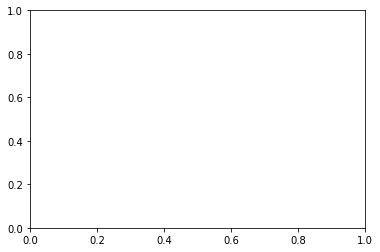

In [34]:
from sklearn.model_selection import KFold

    
fig, ax = plt.subplots()


n_dataset = len(Xc)
n_splits = 3

fprs = []
tprs = []
thrs = []

kf = KFold(n_splits = n_splits)
for train, test in kf.split(range(n_dataset)):
    print("%s %s" % (train, test))
    
    x_train, x_test, y_train, y_test = split_data(train, test)
    
    model = get_model()
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=200, batch_size=1000, verbose=0)
    y_pred = model.predict(x_test)
    
    fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
    
    fprs.append(fpr)
    tprs.append(tpr)
    thrs.append(thr)

    roc_auc = metrics.auc(fpr, tpr)

    metrics_classification_report = metrics.classification_report(y_test, np.round(y_pred))
#     print metrics.classification_report(y_test, np.round(y_pred))

    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Luck')

ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])

# train

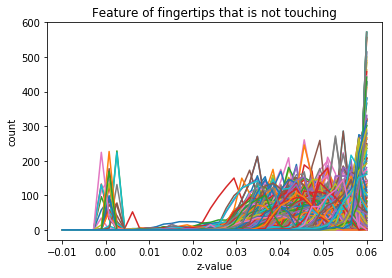

In [629]:
error = []
xasdas = 0
for i in range(len(f_train_feature)):
    if(not (f_train_istouch[i])):
        if(np.mean(f_train_feature[i][20:])<np.mean(f_train_feature[i][:20])):
            error.append(i)
        else:
            xasdas +=1
            plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i])
            plt.xlabel("z-value")
            plt.ylabel("count")
            plt.title("Feature of fingertips that is not touching")

In [454]:
xasdas

345

In [455]:
for i in error:
    v = pptk.viewer(detect_tips_area[i])
    v.play([[f_train_point[i][0], f_train_point[i][1],f_train_point[i][2], 1 * np.pi/2, np.pi/4, 0.5]])
    plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i])

In [456]:
len(error)

0

In [444]:
f_train_istouch = np.array(f_train_istouch)

In [445]:
f_train_istouch[error] = True

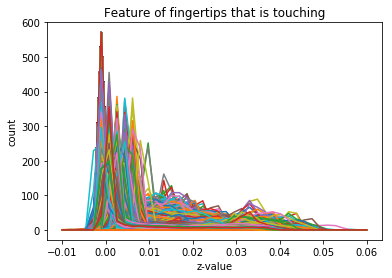

In [630]:
error = []
for i in range(len(f_train_feature)):
    if((f_train_istouch[i])):
        if(np.mean(f_train_feature[i][15:])>np.mean(f_train_feature[i][:15])):
            error.append(i)
        else:
            plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i])
            plt.xlabel("z-value")
            plt.ylabel("count")
            plt.title("Feature of fingertips that is touching")

In [458]:
for i in error:
    plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i])

In [459]:
len(error)

0

In [328]:
f_train_istouch[error] = False

1920


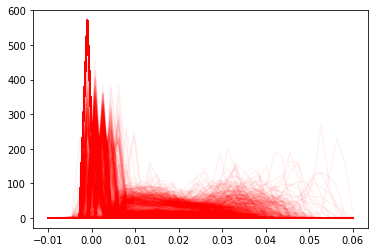

In [637]:
#isTouch
isTouch = []
isTouch_label = []
total_isTouch=0
for i in range(len(f_train_feature)):
    if((f_train_istouch[i])):
        total_isTouch+=1
        isTouch.append(f_train_feature[i])
        isTouch_label.append(True)
        plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i],'r-', alpha=0.05)
print(total_isTouch)

651


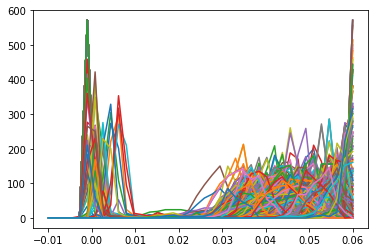

In [638]:
#not touch
not_touch = []
notTouch_label = []
total_notTouch=0
for i in range(len(f_train_feature)):
    if(not (f_train_istouch[i])):
        total_notTouch+=1
        not_touch.append(f_train_feature[i])
        notTouch_label.append(False)
        plt.plot(np.linspace(-0.01, 0.06, 40),f_train_feature[i])
print(total_notTouch)

In [640]:
selection = np.random.choice(total_isTouch, total_notTouch, replace=False)
f_train_feature = [isTouch[x] for x in selection] + not_touch
f_train_istouch = [isTouch_label[x] for x in selection] + notTouch_label

In [641]:
print(len(f_train_istouch))

1302


In [642]:
feature.close()

AttributeError: 'numpy.ndarray' object has no attribute 'close'

In [643]:
feature = h5py.File('feature.hdf5', 'w')
feature['feature'] = f_train_feature
feature['label'] = f_train_istouch
feature.close()

# Feature random

In [78]:
random_order_idx = np.array(list(range(len(f_train_feature))))
np.random.shuffle(random_order_idx)
len(random_order_idx)

1412

In [79]:
k_fold_10_idx = []
for i in range(10):
    shift = len(random_order_idx)/10
    k_fold_10_idx.append(random_order_idx[int(0+shift*i):int(shift+shift*i)])

In [80]:
k_fold_10_idx[0:1]

[array([ 996, 1230,  822,  297, 1308, 1130,  458, 1357,  987,  453, 1295,
         388, 1329,  206,   12,  907,  971,  784,  960,  117,  398, 1014,
         981, 1378,   33, 1123,  493, 1056,  146,  279,  512,  286,  318,
         879,  809,  982,  360,  353,  362, 1108,  168,  243,  420,  284,
        1395, 1129,  617,  236, 1292,  800, 1093,  357,  712,   29, 1377,
        1224,  120, 1383,  864,  801,  361,  895,  863,  630,  366,  127,
         989,  134,  337,  432, 1072,  347, 1281,  401,  183,  662,   63,
         200, 1032,  288,  545, 1110,  311,  517,  380,   32, 1133,  122,
         905, 1047,  269,  151, 1094, 1237, 1290,  541, 1161,  615,  720,
         856,  687,  213,  162,  964,  138,  326, 1045, 1216,  382,    3,
        1300,  592, 1304,  522,  379, 1235,  528,  914,  188,  516,  740,
         172,  643,  688,  832, 1173,  413,  310,  794, 1091,  706,  327,
        1156,  671, 1339, 1293,  416,   55,  319,  397,  869])]

In [81]:
k_fold_10_idx[1:len(k_fold_10_idx)]

[array([ 680, 1076, 1203,  668,  187,  709, 1134,  650,  329,  637, 1276,
         244,  718,  137, 1198,   95,  913, 1315,  574, 1179,  486,  778,
         900,  855,  157,  143,  546,  840,  431,  795, 1345, 1145, 1101,
         330,  958,  562,  525,   23,  333,  224,  435,  306,  737, 1342,
         292, 1288,  703, 1038, 1222,  123,   74, 1121, 1036,  245, 1347,
         536,   21,  782,  202,   31, 1205,  930, 1364,  636,  962,  199,
         341,   66,    6,  990,  282, 1015,  166,  153,  820,   56, 1280,
         773, 1410, 1049,  723,  383,  214,  735,  978,  335,  377, 1081,
         296,  481, 1004,   78,  359,  526,  509,  249,  561,  950,  344,
        1086,  929,  897,  247, 1282,  646,  555,  248, 1363,  457,  437,
          53, 1117,  386, 1017,  697,  342,   89,  626, 1200, 1227,  405,
         935,  381,  513,  653,  760,  300, 1215, 1351,  622, 1082,   85,
        1158,  367, 1411,   20, 1043,  834,  315, 1247,  354]),
 array([  47, 1239,  694,  676, 1065, 1368,  208

In [82]:
len(f_train_point)

1412

In [83]:
k_fold_10_idx[1]

array([ 680, 1076, 1203,  668,  187,  709, 1134,  650,  329,  637, 1276,
        244,  718,  137, 1198,   95,  913, 1315,  574, 1179,  486,  778,
        900,  855,  157,  143,  546,  840,  431,  795, 1345, 1145, 1101,
        330,  958,  562,  525,   23,  333,  224,  435,  306,  737, 1342,
        292, 1288,  703, 1038, 1222,  123,   74, 1121, 1036,  245, 1347,
        536,   21,  782,  202,   31, 1205,  930, 1364,  636,  962,  199,
        341,   66,    6,  990,  282, 1015,  166,  153,  820,   56, 1280,
        773, 1410, 1049,  723,  383,  214,  735,  978,  335,  377, 1081,
        296,  481, 1004,   78,  359,  526,  509,  249,  561,  950,  344,
       1086,  929,  897,  247, 1282,  646,  555,  248, 1363,  457,  437,
         53, 1117,  386, 1017,  697,  342,   89,  626, 1200, 1227,  405,
        935,  381,  513,  653,  760,  300, 1215, 1351,  622, 1082,   85,
       1158,  367, 1411,   20, 1043,  834,  315, 1247,  354])

In [84]:
class Confusion(object):
    def __init__(self):
        self.TPL = []
        self.TNL = []
        self.FPL = []
        self.FNL = []
        self.detection = 0

    @property
    def TP(self):
        return len(self.TPL)
    @property
    def TN(self):
        return len(self.TNL)
    @property
    def FP(self):
        return len(self.FPL)
    @property
    def FN(self):
        return len(self.FNL)

    @property
    def recall(self):
        if (self.TP+self.FN) == 0:
            return -1
        return self.TP/(self.TP+self.FN)

    @property
    def precision(self):
        if (self.TP+self.FP) == 0:
            return -1
        return self.TP/(self.TP+self.FP)

    @property
    def Sensitivity(self):
        if (self.TP+self.FN) == 0:
            return -1
        return self.TP/(self.TP+self.FN)

    @property
    def Specificity(self):
        if (self.TN+self.FP) == 0:
            return -1
        return self.TN/(self.TN+self.FP)

    def combine(self, neighbor):
        new = Confusion()
        new.detection = self.detection + neighbor.detection
        new.TPL = [*self.TPL, *neighbor.TPL]
        new.TNL = [*self.TNL, *neighbor.TNL]
        new.FPL = [*self.FPL, *neighbor.FPL]
        new.FNL = [*self.FNL, *neighbor.FNL]
        return new

    def show(self):
        print("Total detection: {:d}".format(self.detection))
        print("True  Positive : {:d}".format(self.TP))## tips detected and is labeled
        print("False Positive : {:d}".format(self.FP))## tips detected and not labeled
        print("True  Negative : {:d}".format(self.TN))## tips not detected and not labeled (5-not show finger)
        print("False Negative : {:d}".format(self.FN))## tips not detected and is labeled
        print("recall : {:f}".format(self.recall))
        print("precision : {:f}".format(self.precision))
        print()



In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

def train(x_train, y_train, evaluation_data, evaluation_label):
    model = Sequential()
    model.add(Dense(64, input_dim=40, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=1000, batch_size=1000, verbose=0)
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    touch_detection = Confusion()
    
    y_predict = model.predict(evaluation_data)
    for i in range(len(y_predict)):
        if(y_predict[i]>=0.5):
            if(evaluation_label[i]):
                touch_detection.TPL.append(1)
            else:
                touch_detection.FPL.append(1)
        else:
            if(not evaluation_label[i]):
                touch_detection.TNL.append(1)
            else:
                touch_detection.FNL.append(1)
    
    touch_detection.show()
    return history, touch_detection, model

In [52]:
from sklearn import metrics
def get_model():
    model = Sequential()
    model.add(Dense(64, input_dim=40, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

-------------------------
0
-------------------------
-------------------------
1
-------------------------
-------------------------
2
-------------------------
-------------------------
3
-------------------------
-------------------------
4
-------------------------
-------------------------
5
-------------------------
-------------------------
6
-------------------------
-------------------------
7
-------------------------
-------------------------
8
-------------------------
-------------------------
9
-------------------------


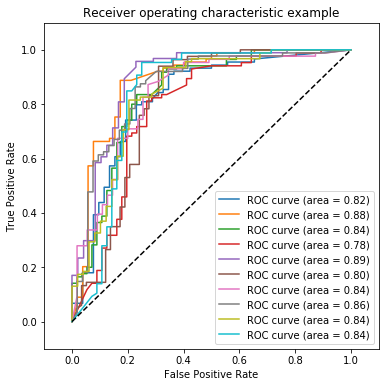

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

from functools import reduce
model = []
f_train_feature = np.array(f_train_feature)
f_train_istouch = np.array(f_train_istouch)

fprs = []
tprs = []
thrs = []
fig, ax = plt.subplots(figsize=(6,6))
for term in range(len(k_fold_10_idx)):
    term_train_idx = []
    for j in range(len(k_fold_10_idx)):
        if(term==j):
            evaluation_data = f_train_feature[np.array(k_fold_10_idx[j])]
            evaluation_label = f_train_istouch[np.array(k_fold_10_idx[j])]
        else:
#             train_idx = list(reduce(lambda x, y: np.concatenate((x,y)),train_idx))
            term_train_idx.append(k_fold_10_idx[j])
    term_train_idx = list(reduce(lambda x, y: np.concatenate((x,y)),term_train_idx))
    train_data = f_train_feature[np.array(term_train_idx)]
    train_label = f_train_istouch[np.array(term_train_idx)]
    print("-------------------------")
    print(term)
    print("-------------------------")
#     model.append(train(train_data, train_label, evaluation_data, evaluation_label))
    
    
#     print("%s %s" % (train, test))
    
    x_train, x_test, y_train, y_test = train_data, evaluation_data, train_label, evaluation_label
    
    model = get_model()
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=1000, batch_size=1000, verbose=0)
    y_pred = model.predict(x_test)
    
    fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
    
    fprs.append(fpr)
    tprs.append(tpr)
    thrs.append(thr)

    roc_auc = metrics.auc(fpr, tpr)

    metrics_classification_report = metrics.classification_report(y_test, np.round(y_pred))
#     print metrics.classification_report(y_test, np.round(y_pred))

    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")    
ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Luck')

ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
plt.show()

-------------------------
0
-------------------------


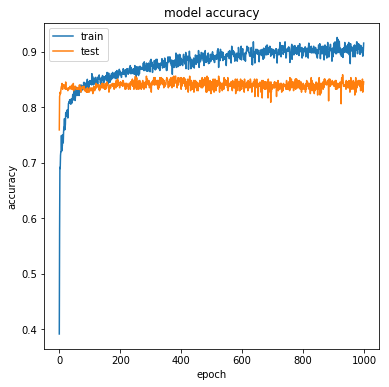

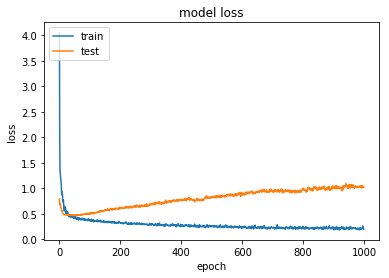

Total detection: 0
True  Positive : 76
False Positive : 13
True  Negative : 39
False Negative : 13
recall : 0.853933
precision : 0.853933

-------------------------
1
-------------------------


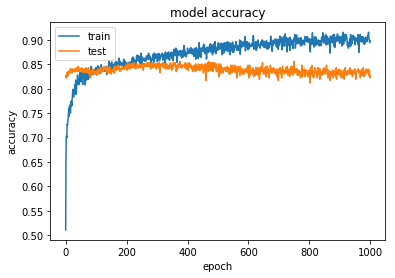

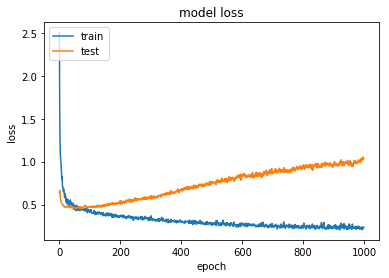

Total detection: 0
True  Positive : 80
False Positive : 12
True  Negative : 40
False Negative : 9
recall : 0.898876
precision : 0.869565

-------------------------
2
-------------------------


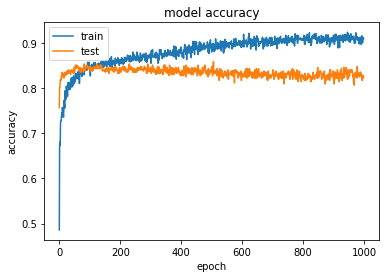

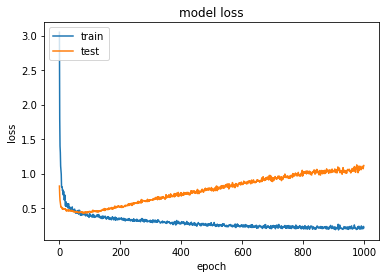

Total detection: 0
True  Positive : 72
False Positive : 16
True  Negative : 40
False Negative : 13
recall : 0.847059
precision : 0.818182

-------------------------
3
-------------------------


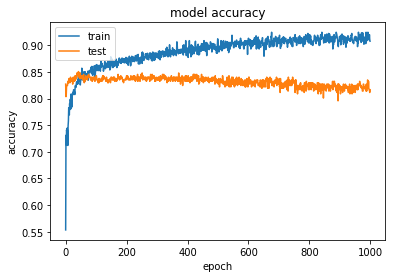

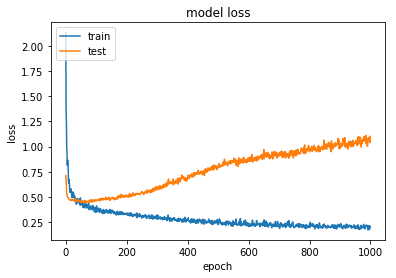

Total detection: 0
True  Positive : 77
False Positive : 22
True  Negative : 34
False Negative : 8
recall : 0.905882
precision : 0.777778

-------------------------
4
-------------------------


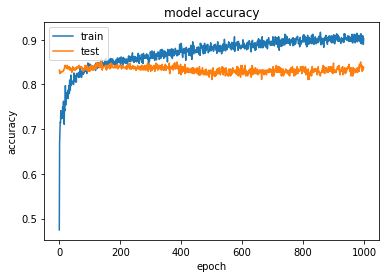

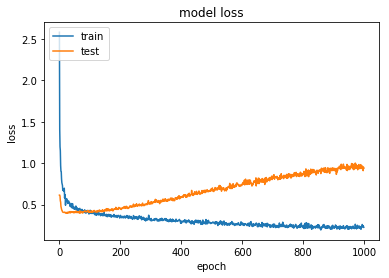

Total detection: 0
True  Positive : 84
False Positive : 11
True  Negative : 37
False Negative : 10
recall : 0.893617
precision : 0.884211

-------------------------
5
-------------------------


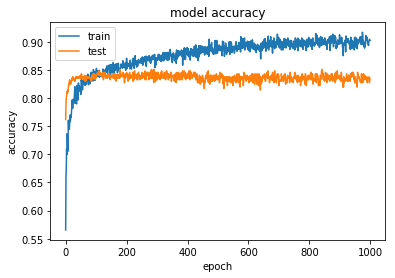

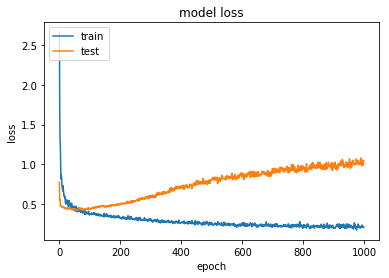

Total detection: 0
True  Positive : 81
False Positive : 19
True  Negative : 39
False Negative : 2
recall : 0.975904
precision : 0.810000

-------------------------
6
-------------------------


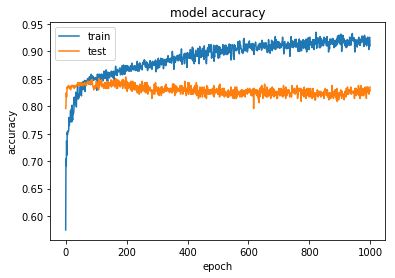

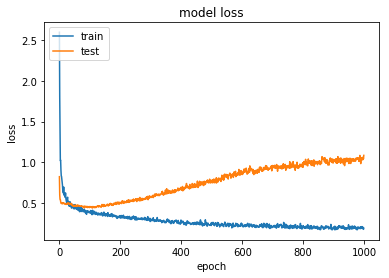

Total detection: 0
True  Positive : 76
False Positive : 17
True  Negative : 38
False Negative : 10
recall : 0.883721
precision : 0.817204

-------------------------
7
-------------------------


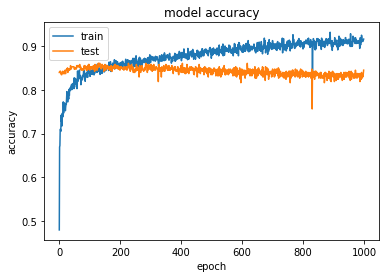

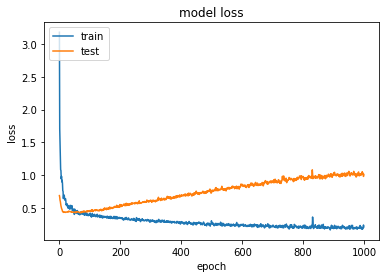

Total detection: 0
True  Positive : 79
False Positive : 14
True  Negative : 39
False Negative : 9
recall : 0.897727
precision : 0.849462

-------------------------
8
-------------------------


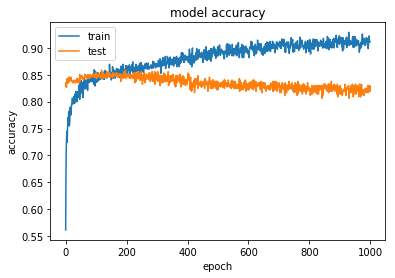

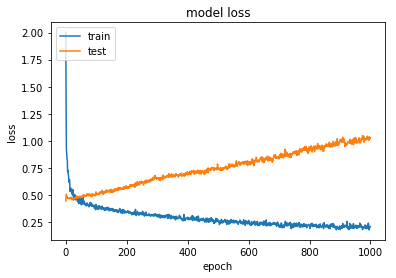

Total detection: 0
True  Positive : 78
False Positive : 11
True  Negative : 38
False Negative : 14
recall : 0.847826
precision : 0.876404

-------------------------
9
-------------------------


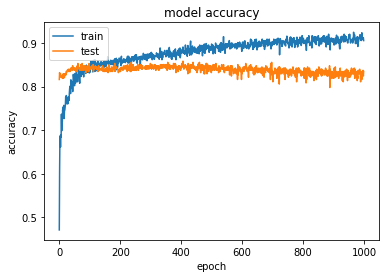

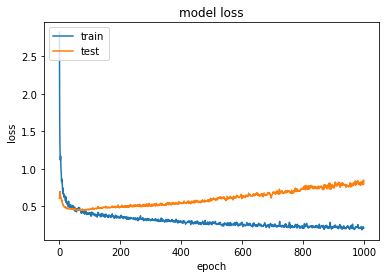

Total detection: 0
True  Positive : 78
False Positive : 14
True  Negative : 42
False Negative : 8
recall : 0.906977
precision : 0.847826



In [88]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

from functools import reduce
model = []
f_train_feature = np.array(f_train_feature)
f_train_istouch = np.array(f_train_istouch)

fprs = []
tprs = []
thrs = []
fig, ax = plt.subplots(figsize=(6,6))
for term in range(len(k_fold_10_idx)):
    term_train_idx = []
    for j in range(len(k_fold_10_idx)):
        if(term==j):
            evaluation_data = f_train_feature[np.array(k_fold_10_idx[j])]
            evaluation_label = f_train_istouch[np.array(k_fold_10_idx[j])]
        else:
#             train_idx = list(reduce(lambda x, y: np.concatenate((x,y)),train_idx))
            term_train_idx.append(k_fold_10_idx[j])
    term_train_idx = list(reduce(lambda x, y: np.concatenate((x,y)),term_train_idx))
    train_data = f_train_feature[np.array(term_train_idx)]
    train_label = f_train_istouch[np.array(term_train_idx)]
    print("-------------------------")
    print(term)
    print("-------------------------")
    model.append(train(train_data, train_label, evaluation_data, evaluation_label))


In [89]:
final_model = model[4][2]
touch_detection = Confusion()

detect_tips_feature = np.array(list(map(area2feature, detect_tips_area)))
detect_tips_istouch

y_predict = final_model.predict(detect_tips_feature)
for i in range(len(y_predict)):
    if(y_predict[i]>=0.5):
        if(detect_tips_istouch[i]):
            touch_detection.TPL.append(1)
        else:
            touch_detection.FPL.append(1)
    else:
        if(not detect_tips_istouch[i]):
            touch_detection.TNL.append(1)
        else:
            touch_detection.FNL.append(1)

touch_detection.show()

Total detection: 0
True  Positive : 831
False Positive : 92
True  Negative : 443
False Negative : 46
recall : 0.947548
precision : 0.900325



In [90]:
final_model.save('new_touch_model.hdf5.h5')

# error fix

In [246]:
nan = 0
for i in range(len(train_feature)):
    if(np.isnan(train_feature[i][0])):
        nan+=1
        print(i)
nan

16
85
151
201
230
232
239
240
242
244
249
252
258
260
261
265
266
268
270
273
277
278
281
285
286
288
290
293
296
297
299
300
304
308
309
313
317
319
320
326
332
338
344
347
350
351
355
356
360
362
363
364
370
374
376
379
382
385
387
388
390
395
399
403
406
407
410
413
415
420
427
433
436
437
439
440
442
445
447
453
457
458
462
463
464
465
467
470
471
474
476
479
483
484
485
488
489
491
499
511
516
518
520
531
533
534
536
537
543
549
550
555
556
560
562
569
576
580
586
589
594
595
600
606
608
611
614
616
621
622
626
627
635
636
639
640
641
643
644
646
647
648
649
652
654
658
666
667
674
675
677
686
689
693
698
699
701
704
706
708
711
712
715
716
717
718
719
722
726
731
733
734
735
736
739
743
744
746
747
749
752
755
756
757
759
762
764
765
770
773
778
780
781
784
786
788
792
796
801
804
809
816
821
823
827
835
838
839
843
847
848
851
855
860
862
866
869
872
875
876
880
883
884
887
891
892
894
896
900
904
905
909
914
915
918
922
926
929
934
936
942
944
948
951
955
959
965
969
971
979
98

779

In [237]:
total = 0
for i in ex2data:
    for j in range(20):
        r = list_label_processing([i],[j])
        total += len(r[0][0])
        if(total> 16):
            print(j)
            break
    break

E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5


E:\ProgramFiles\anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5
5


In [100]:
pptk.viewer(train_area[4])

In [239]:
list_label_processing(['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5'],[5])[0][1]

E:\User\workspace\multi-touch\experiement\recording\ex2_20190131_171522\Vhdf5_ex2_20190131_171522.hdf5


E:\ProgramFiles\anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


[array([[0.04254153, 0.05870674, 0.02957297],
        [0.04356634, 0.0585816 , 0.02970728],
        [0.04486812, 0.05965098, 0.02898701],
        ...,
        [0.05109634, 0.03426474, 0.02008264],
        [0.05207054, 0.03404616, 0.02028847],
        [0.05301843, 0.03373174, 0.02056979]]),
 array([[-0.01330613,  0.00940512,  0.0292949 ],
        [-0.01234274,  0.00968065,  0.02910109],
        [-0.01138726,  0.00985919,  0.0289867 ],
        ...,
        [-0.0014269 , -0.03887868,  0.00056878],
        [-0.00051377, -0.03881061,  0.00050428],
        [ 0.00040034, -0.03874271,  0.00043979]]),
 array([[-0.06426881,  0.01127064,  0.03070265],
        [-0.06336807,  0.01155773,  0.03050615],
        [-0.06246101,  0.01174547,  0.03039014],
        ...,
        [-0.05992477, -0.03887445,  0.00099165],
        [-0.05905202, -0.03888551,  0.00102206],
        [-0.05817907, -0.03889669,  0.00105241]]),
 array([[-0.10073169,  0.03762609,  0.08493   ],
        [-0.09982985,  0.03751399,  0.0850

['IR', 'color', 'depth', 'pcl_center', 'trans_matrix']


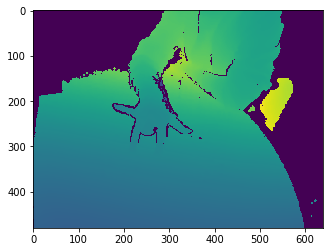

In [242]:
test_homography('E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5',5)

In [104]:
label_result[0]

([array([-0.03204091,  0.01710514,  0.01102569], dtype=float32),
  array([-0.09385743,  0.03163763,  0.02536388], dtype=float32),
  array([-0.07347732,  0.02319476,  0.0094738 ], dtype=float32),
  array([-0.04654988, -0.33475134,  0.3111426 ], dtype=float32),
  array([-0.04654988, -0.33475134,  0.3111426 ], dtype=float32),
  array([-0.06349463,  0.01555497,  0.01000813], dtype=float32),
  array([-0.04654988, -0.33475134,  0.3111426 ], dtype=float32),
  array([-0.02169556, -0.00573907,  0.0074252 ], dtype=float32),
  array([-0.05206121,  0.00306229,  0.0295694 ], dtype=float32),
  array([0.07130218, 0.03847618, 0.03419447], dtype=float32),
  array([-0.00206392, -0.03068586,  0.03331743], dtype=float32),
  array([-0.03121916, -0.00765137,  0.01147302], dtype=float32),
  array([-0.05577147, -0.01522293,  0.02135568], dtype=float32),
  array([0.05889742, 0.03409774, 0.02946912], dtype=float32),
  array([-0.00606847, -0.01082617,  0.00869181], dtype=float32),
  array([-0.05945908, -0.010643

In [ ]:
list_label_processing(['E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5'],[2])

In [107]:
test_homography('E:\\User\\workspace\\multi-touch\\experiement\\recording\\ex2_20190131_171522\\Vhdf5_ex2_20190131_171522.hdf5',2)

['IR', 'color', 'depth', 'pcl_center', 'trans_matrix']


In [ ]:
plt.im